In [1]:
"""
State estimation and parameter estimation for the 2-layer QG system with only surface observations (hidden flow states and unknown topography)
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde, norm
from Lagrangian_tracer import Lagrange_tracer_model
from conj_symm_tools import verify_conjugate_symmetry, find_non_conjugate_pairs, avg_conj_symm, map_conj_symm
from Lagrangian_DA import Lagrangian_DA_OU, Lagrangian_DA_CG, mu2psi, mu2layer, R2layer, relative_entropy_psi_k
from ene_spectrum import ene_spectrum, adjust_ik, trunc2full
from LSM_QG import solve_eigen, calibrate_OU, run_OU, eigen2layer, layer2eigen, growth_rate
from mode_truc import inv_truncate, truncate
from plot import ifftnroll, psi2q, plot_contour_fields, plot_psi_k_seriespdf, plot_layer_seriespdf, plot_psi1_k_seriespdf, plot_rmses, loop_ifft2_var, ifft2_var, plot_mog, plot_mog_k, scatterplot, calculate_skewness_kurtosis
from statsmodels.tsa.stattools import acf, ccf
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy import sparse
import h5py
from time import time

# fix the random seed
np.random.seed(2024)


# 0. Control run (truth)

In [3]:
# load data
data_path = '../data/qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt1e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [6]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.1
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta22_h40.npz', **obs)

/grad/wang3262/Proj_2_DAnPE_CGKN/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/grad/wang3262/Proj_2_DAnPE_CGKN/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [4]:
# truncate parameter
r_cut = 16
style = 'circle'

In [5]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

# np.savez('../data/eigens_K128_beta22.npz', **eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [6]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

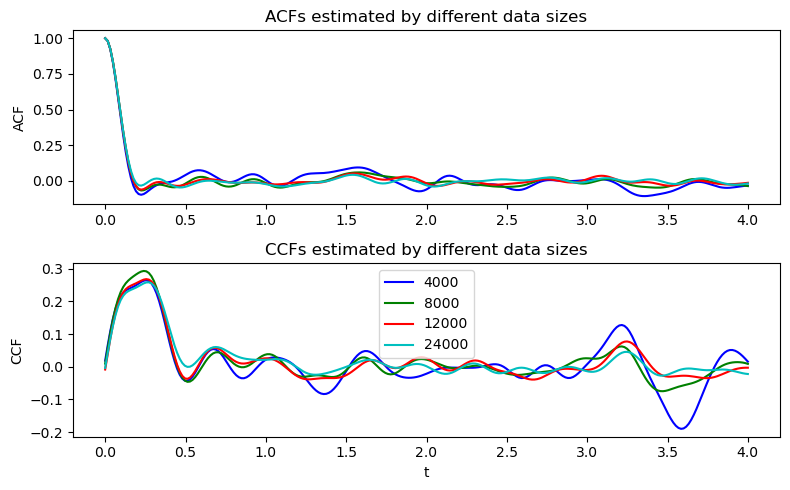

In [8]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [4000, 8000, 12000, 24000]
Lag = 250  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('../figure/acf_ccf_diffN_K128_beta22_tr_h40.png')
plt.show()

In [9]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=False)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.savez('../data/est_paras_ou_K128_beta22_tr_h40.npz', **est_params)

/grad/wang3262/Proj_2_DAnPE_CGKN/code/LSM_QG.py:123: OptimizeWarning: Covariance of the parameters could not be estimated
  x1, _ = curve_fit(ACF, tt, acf_psi, p0=x0, check_finite=True, maxfev=2000)


# 1. Reduced-order stochastic models

In [2]:
# load data
data_path = '../data/qg/QG_DATA_topo32_nu1e-12_beta22_K128_dt1e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [6]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.1
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta22_h32.npz', **obs)

/grad/wang3262/Proj_2_DAnPE_CGKN/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/grad/wang3262/Proj_2_DAnPE_CGKN/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [3]:
# truncate parameter
r_cut = 16
style = 'circle'

### 1.1 Linear stochastic models of eigenmodes

In [10]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.savez('../data/eigens_K128_beta22.npz', **eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [11]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

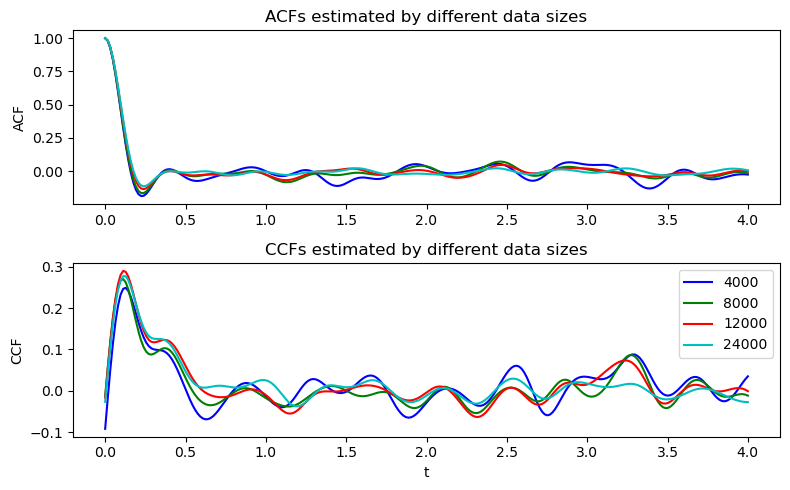

In [12]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [4000, 8000, 12000, 24000]
Lag = 250  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('../figure/acf_ccf_diffN_K128_beta22_tr_h32.png')
plt.show()

In [13]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=False)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.savez('../data/est_paras_ou_K128_beta22_tr_h32.npz', **est_params)

/grad/wang3262/Proj_2_DAnPE_CGKN/code/LSM_QG.py:123: OptimizeWarning: Covariance of the parameters could not be estimated
  x1, _ = curve_fit(ACF, tt, acf_psi, p0=x0, check_finite=True, maxfev=2000)


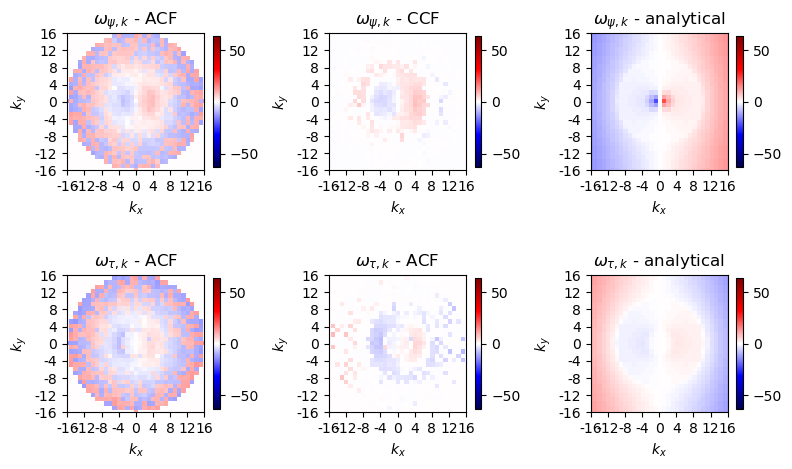

In [14]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('../figure/omega_compare_K128_beta22_tr_h32.png', dpi=100)
plt.show()

In [15]:
# Run OU process
N = 40000
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate, corr_noise=False)

# # save data
# ou_run = {
#     'psi_k': psi_k,
#     'tau_k': tau_k,
#     'N': N,
#     'r_cut':r_cut,
#     'dt': dt
# }
# np.savez('../data/ou_run_K128_beta22_tr_h20.npz', **ou_run)

In [16]:
# ifft to real space
interv = 5
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)

psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [17]:
psi1_ifft_t = psi1_ifft_t[:,:,:500]
psi2_ifft_t = psi2_ifft_t[:,:,:500]

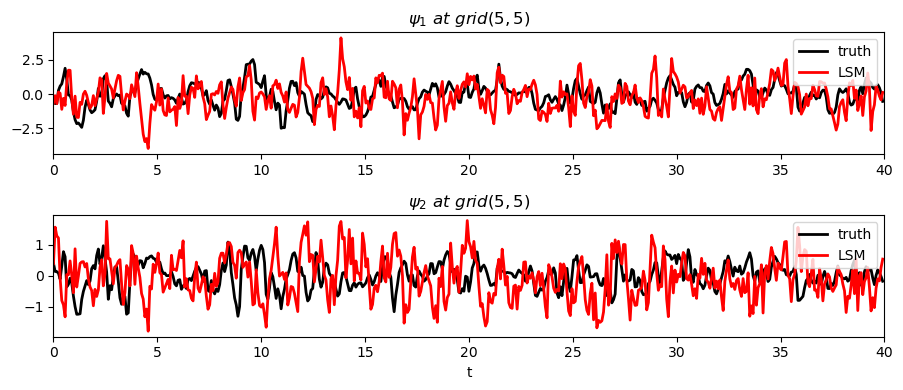

In [18]:
# Plotting trajectories
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'k', linewidth=2, label='truth')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'r', linewidth=2, label='LSM')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('../figure/psi_layer_ou_truth_K128_beta22_tr_h32.png', dpi=100)
plt.show()

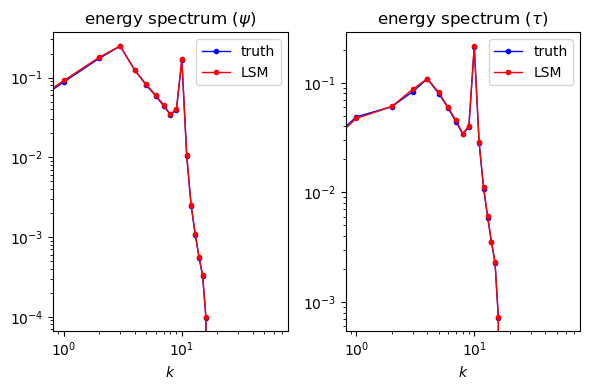

In [19]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('../figure/spectrum_eigen_K128_beta22_tr_h32.png', dpi=100)
plt.show()

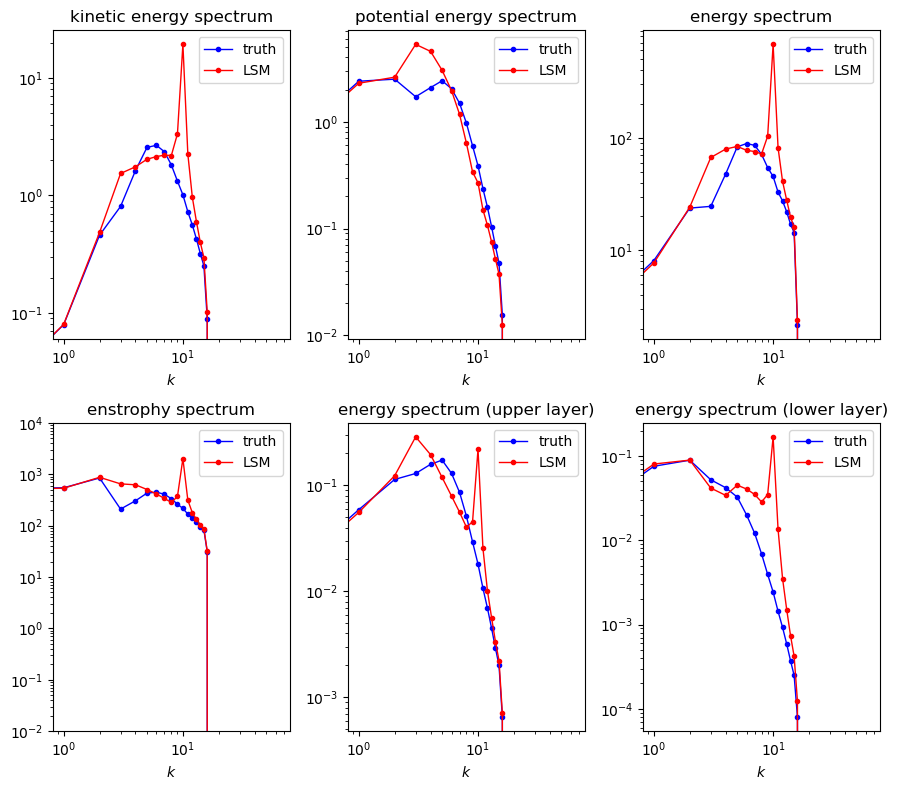

In [20]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 3, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('../figure/spectrum_layer_K128_beta22_tr_h32.png', dpi=100)
plt.show()

# 2. Data assimilation

In [65]:
# load data
data_path = '../data/qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt1e-3_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    # psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [66]:
# DA is evaluated on the last 100000 steps
psi1_k_t = psi1_k_t[:, :, 18750:]
psi2_k_t = psi2_k_t[:, :, 18750:]

In [4]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
obs = np.load('../data/obs_K128_beta22_h40.npz')
xt = obs['xt']
yt = obs['yt']
L = 256
xt = xt[:L, :]
yt = yt[:L, :]
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256_iter0.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']

In [5]:
# truncate parameter
r_cut = 16
style = 'circle'

In [6]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

#### check sigma and f_est

/grad/wang3262/miniconda3/envs/py/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/grad/wang3262/miniconda3/envs/py/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


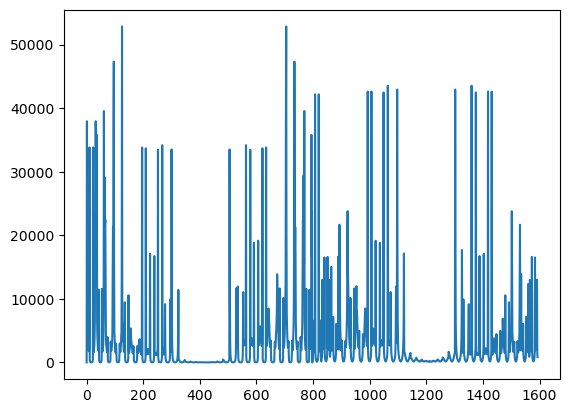

In [9]:
plt.plot(R_t_lsm[:,1])

In [10]:
plt.plot(truncate(sigma_est, r_cut, style).flatten())

NameError: name 'sigma_est' is not defined

In [175]:
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h20.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

print(f_est[0,1,:])
print(f_est[2,0,:])

[3704.89735097+9088.5587856j  3055.12291545+3137.59206899j]
[1158.58162652 +569.88896309j 3568.38632251+1967.34234696j]


In [151]:
f1, f2 = eigen2layer(K,r_cut, r1,r2,f_est[:,:,0][:,:,None],f_est[:,:,1][:,:,None])
print(f1[0,1,:], f2[0,1,:])
print(f1[2,0,:], f2[2,0,:])

[477.81852866+4391.33290813j] [4557.82248906+8244.86630647j]
[-2009.1408876-1164.27052363j] [2651.90945003+1422.80559971j]


In [173]:
est_params = np.load('/grad/wang3262/Proj_1_LagrangeDA/data/est_paras_ou_K128_beta22_tr.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

print(f_est[0,1,:])
print(f_est[2,0,:])

[2260.18385541+4063.34589082j 2567.99875041+1860.14448701j]
[2066.89512535+593.32456617j 2958.11415517  -5.01903217j]


In [155]:
f1, f2 = eigen2layer(K,r_cut, r1,r2,f_est[:,:,0][:,:,None],f_est[:,:,1][:,:,None])
print(f1[0,1,:], f2[0,1,:])
print(f1[2,0,:], f2[2,0,:])

[-228.8159566+1625.35659857j] [3255.05644509+3994.35569141j]
[-756.48349942+491.63260464j] [2829.14671424+335.44320074j]


#### DA

##### iter0

In [8]:
mu_t_lsm = mu_t_lsm[:, s_rate-1::s_rate]
mu_t_lsm.shape

(1594, 6250)

In [9]:
# reshape flattened variables to two modes matrices
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)

In [12]:
N = 100000

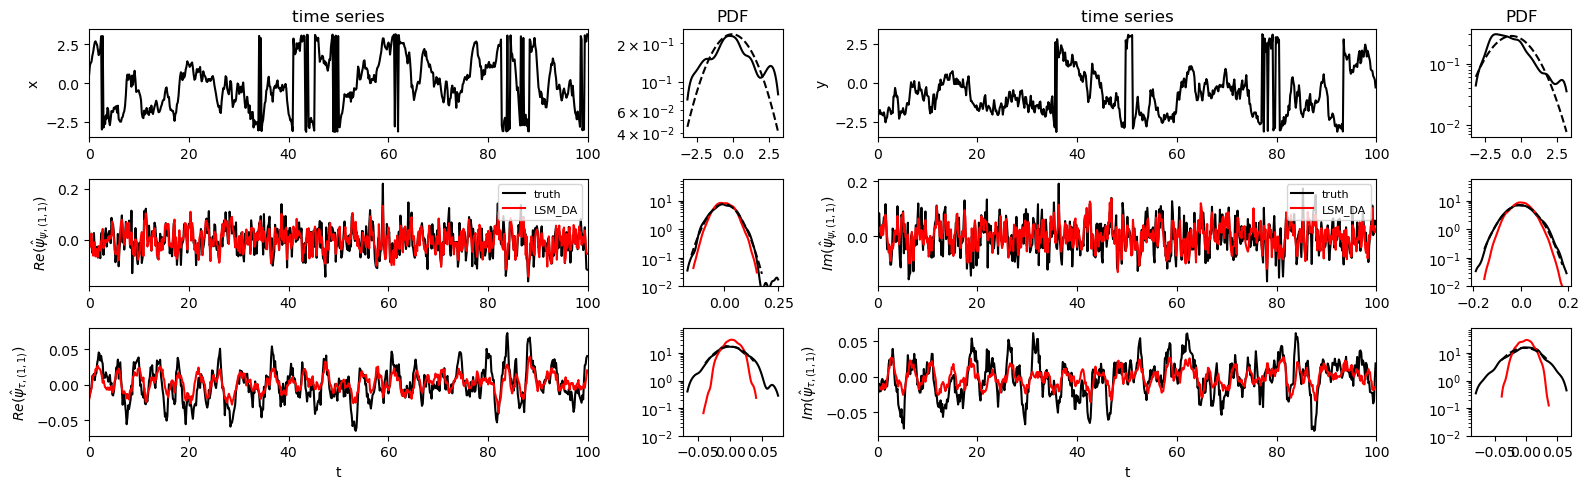

In [14]:
# Plot
sel0 = 0//s_rate; sel1 = N//s_rate # plot time range
ikx = 1; iky = 1 # mode to plot
interv = 10 # plot interval
xlim = (0,100)
ylim = (1e-2, 50)
data1 = [psi_k_t/K**2, psi_k_pos_lsm/K**2]
data2 = [tau_k_t/K**2, tau_k_pos_lsm/K**2]
labels = ['truth', 'LSM_DA', 'LSM_corr_DA']
ylabels = ['\psi', '\tau']
colors = ['k', 'r', 'c']
plot_psi_k_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, xt[:,:N:s_rate], yt[:,:N:s_rate], data1, data2, labels, colors)
# plt.savefig('./Lagrangian_DA/LSMDA_psi_k_K128_beta22_tr16_L256.png',dpi=100)
plt.show()

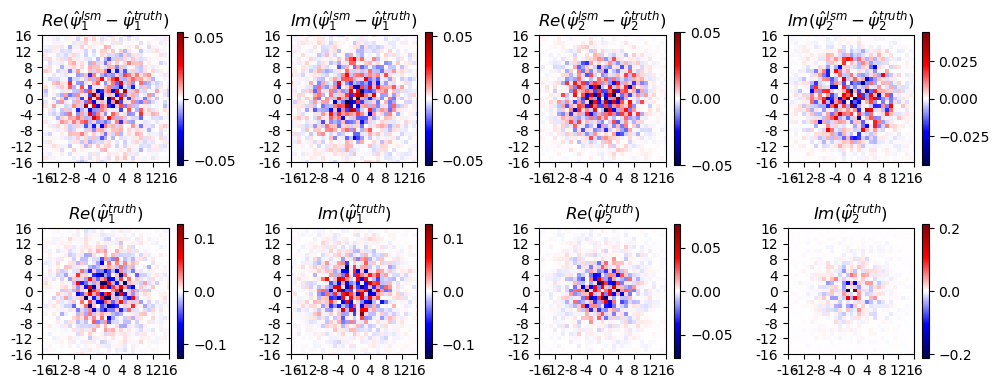

In [15]:
# plot error mode
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)

nrow, ncol = (2,4)
fig, axs = plt.subplots(nrow, ncol, figsize=(10,4))

dataplot = np.zeros((K,K,nrow,ncol))
dataplot[:,:,0,0] = (psi1_k_pos_lsm[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,0,1] = (psi1_k_pos_lsm[:, :, N//s_rate-1] - psi1_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,-1,0] = psi1_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,-1,1] = psi1_k_t[:, :, N//s_rate-1].imag / K**2
dataplot[:,:,0,2] = (psi2_k_pos_lsm[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,0,3] = (psi2_k_pos_lsm[:, :, N//s_rate-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,-1,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,-1,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(nrow):
    for j in range(ncol):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])
        
axs[0,0].set_title(f'$Re(\hat{{\psi}}^{{lsm}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[0,1].set_title(f'$Im(\hat{{\psi}}^{{lsm}}_1 - \hat{{\psi}}^{{truth}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}^{{lsm}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}^{{lsm}}_2 - \hat{{\psi}}^{{truth}}_2)$')
axs[-1,0].set_title(f'$Re(\hat{{\psi}}^{{truth}}_1)$')
axs[-1,1].set_title(f'$Im(\hat{{\psi}}^{{truth}}_1)$')
axs[-1,2].set_title(f'$Re(\hat{{\psi}}^{{truth}}_2)$')
axs[-1,3].set_title(f'$Im(\hat{{\psi}}^{{truth}}_2)$')

plt.tight_layout()
# plt.savefig('./Lagrangian_DA/LSMDA_err_psi_k_K128_beta22_tr16_L256.png', dpi=100)
plt.show()

In [16]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)

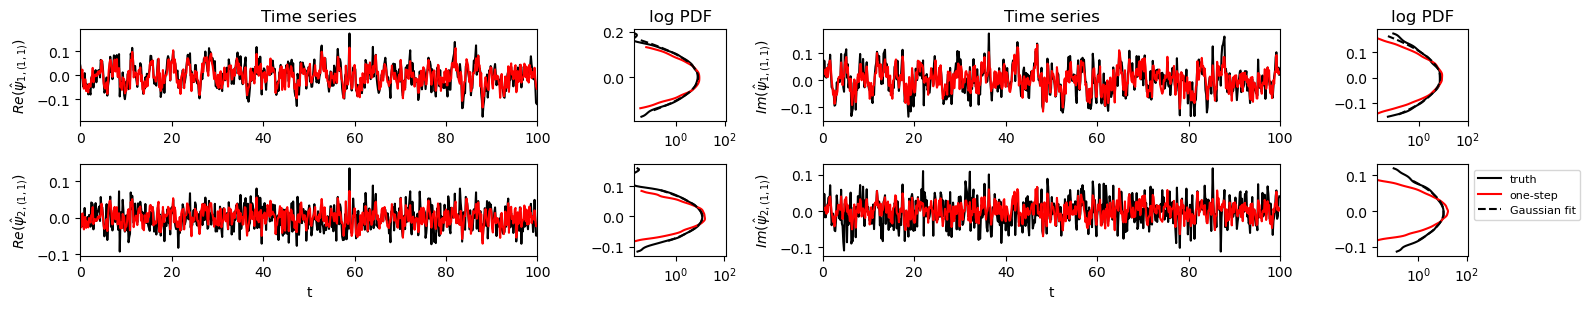

In [21]:
# Plot
sel0 = 0//s_rate; sel1 = N//s_rate # plot time range
ikx = 1; iky = 1 # mode to plot
interv = 10 # plot interval
xlim = (0,100)
ylim = (2e-2, 100)
data1 = [psi1_k_t[:,:,:]/K**2, psi1_k_pos_lsm[:,:,:]/K**2]
data2 = [psi2_k_t[:,:,:]/K**2, psi2_k_pos_lsm[:,:,:]/K**2]
labels = ['truth', 'one-step']
colors = ['k', 'r', 'b']
plot_psi1_k_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, xt[:,100000:N:s_rate], yt[:,100000:N:s_rate], data1, data2, labels, colors)
plt.savefig('../figure/DA_layer_k_K128_beta22_tr16_L256_h32_iter0.png',dpi=100)
plt.show()

In [19]:
psi1_k_t.shape

(128, 128, 6250)

In [20]:
psi1_k_pos_lsm.shape

(128, 128, 6250)

In [22]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t)
psi2_t = ifftnroll(K, psi2_k_t)
psi1_pos_lsm = ifftnroll(K, psi1_k_pos_lsm)
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm)

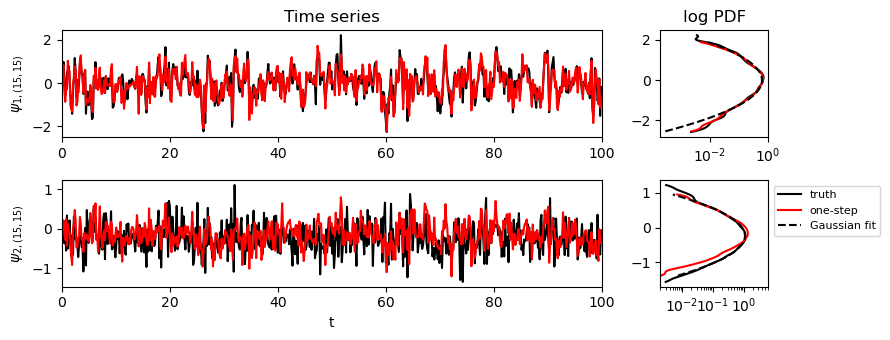

In [24]:
sel0 = 0//(s_rate); sel1 = N//(s_rate) # plot time range
xlim = (0,100)
ylim = (2e-3, 5)
ikx = 15; iky = 15 # x,y to plot
interv = 10
data1 = [psi1_t, psi1_pos_lsm]
data2 = [psi2_t, psi2_pos_lsm]
labels = ['truth', 'one-step']
colors = ['k', 'r', 'b']
plot_layer_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, data1, data2, labels, colors)
plt.savefig('../figure/DA_layer_K128_beta22_tr16_L256_h32_iter0.png',dpi=100)
plt.show()

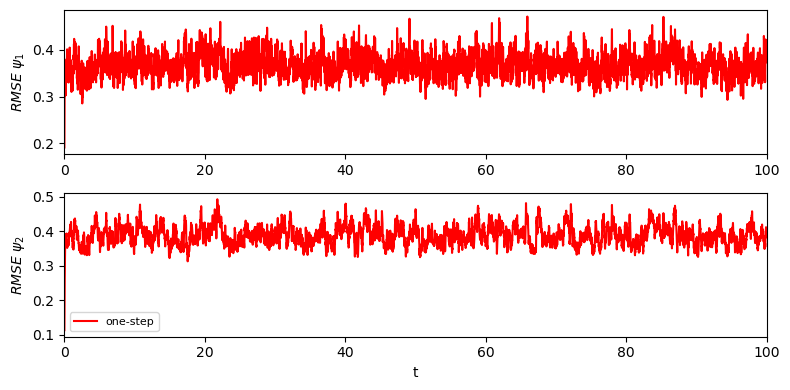

In [25]:
# Plot
rmse1_t_lsm = np.sqrt(np.mean((psi1_pos_lsm - psi1_t)**2, axis=(0,1)))
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
data1 = [rmse1_t_lsm]
data2 = [rmse2_t_lsm]
interv = 1
sel0 = 0//(s_rate); sel1 = N//(s_rate) # plot time range
xlim = (0,100)
labels = ['one-step']
colors = ['r', 'b']
plot_rmses(dt, sel0, sel1, s_rate, interv, xlim, data1, data2, labels, colors)
plt.savefig('../figure/rmses_ens16_K128_beta22_tr16_real_L256_h32_iter0.png',dpi=100)
plt.show()

In [26]:
# RMSE
n_start = 0 # spin up time
rmse1_xy = np.sqrt(np.mean((psi1_pos_lsm[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

LSM DA
RMSE(upper layer): 0.36716248864983514
RMSE(lower layer): 0.3878134530987125


##### iter2

In [69]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
obs = np.load('../data/obs_K128_beta22_h40.npz')
xt = obs['xt']
yt = obs['yt']
L = 256
xt = xt[:L, :]
yt = yt[:L, :]
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256_iter2.npz')
mu_t_lsm = da_pos['mu_t']
R_t_lsm = da_pos['R_t']

In [70]:
# truncate parameter
r_cut = 16
style = 'circle'

In [71]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

In [72]:
mu_t_lsm = mu_t_lsm[:, s_rate-1::s_rate]
mu_t_lsm.shape

(1594, 6250)

In [73]:
# reshape flattened variables to two modes matrices
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)

In [74]:
N = 100000

In [75]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)

In [77]:
# ifft to real space
psi1_t = ifftnroll(K, psi1_k_t)
psi2_t = ifftnroll(K, psi2_k_t)
psi1_pos_lsm = ifftnroll(K, psi1_k_pos_lsm)
psi2_pos_lsm = ifftnroll(K, psi2_k_pos_lsm)

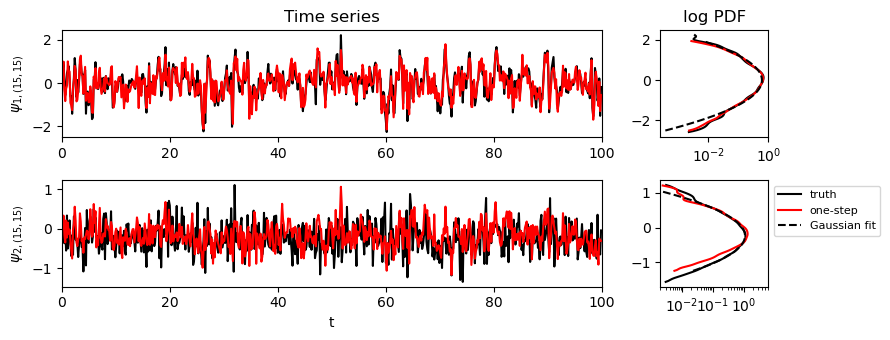

In [78]:
sel0 = 0//(s_rate); sel1 = N//(s_rate) # plot time range
xlim = (0,100)
ylim = (2e-3, 5)
ikx = 15; iky = 15 # x,y to plot
interv = 10
data1 = [psi1_t, psi1_pos_lsm]
data2 = [psi2_t, psi2_pos_lsm]
labels = ['truth', 'one-step']
colors = ['k', 'r', 'b']
plot_layer_seriespdf(dt*s_rate, sel0, sel1, ikx, iky, interv, xlim, ylim, data1, data2, labels, colors)
plt.savefig('../figure/DA_layer_K128_beta22_tr16_L256_h32_iter2.png',dpi=100)
plt.show()

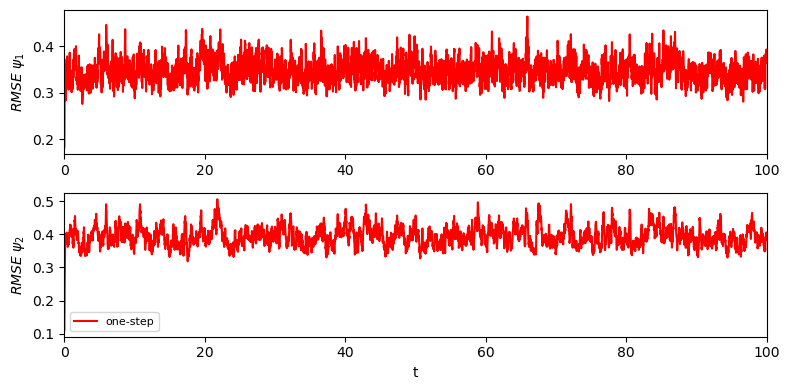

In [79]:
# Plot
rmse1_t_lsm = np.sqrt(np.mean((psi1_pos_lsm - psi1_t)**2, axis=(0,1)))
rmse2_t_lsm = np.sqrt(np.mean((psi2_pos_lsm - psi2_t)**2, axis=(0,1)))
data1 = [rmse1_t_lsm]
data2 = [rmse2_t_lsm]
interv = 1
sel0 = 0//(s_rate); sel1 = N//(s_rate) # plot time range
xlim = (0,100)
labels = ['one-step']
colors = ['r', 'b']
plot_rmses(dt, sel0, sel1, s_rate, interv, xlim, data1, data2, labels, colors)
plt.savefig('../figure/rmses_ens16_K128_beta22_tr16_real_L256_h32_iter2.png',dpi=100)
plt.show()

In [80]:
# RMSE
n_start = 0 # spin up time
rmse1_xy = np.sqrt(np.mean((psi1_pos_lsm[:,:,n_start:] - psi1_t[:,:,n_start:])**2, axis=(0,1)))
rmse2_xy = np.sqrt(np.mean((psi2_pos_lsm[:,:,n_start:] - psi2_t[:,:,n_start:])**2, axis=(0,1)))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('LSM DA')
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

LSM DA
RMSE(upper layer): 0.34722467937836016
RMSE(lower layer): 0.3935652789607252


###### Snapshots of PV flow field

In [26]:
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)

In [16]:
N = 100000
q1_k_t, q2_k_t = psi2q(psi1_k_t[:, :, -N//s_rate:], psi2_k_t[:, :, -N//s_rate:], kd, h_hat)
q1_k_t_lsm, q2_k_t_lsm = psi2q(psi1_k_pos_lsm[:, :, -N//s_rate:], psi2_k_pos_lsm[:, :, -N//s_rate:], kd, h_hat)

In [17]:
# ifft to real space
n_t = -5500
q1_k_t = inv_truncate(truncate(q1_k_t[:, :, n_t], r_cut, style)[:,None], r_cut, K, style)
q2_k_t = inv_truncate(truncate(q2_k_t[:, :, n_t], r_cut, style)[:,None], r_cut, K, style)
q1_t = ifftnroll(K, q1_k_t)[:,:,0]
q2_t = ifftnroll(K, q2_k_t)[:,:,0]
q1_t_lsm = ifftnroll(K, q1_k_t_lsm[:, :, n_t])
q2_t_lsm = ifftnroll(K, q2_k_t_lsm[:, :, n_t])

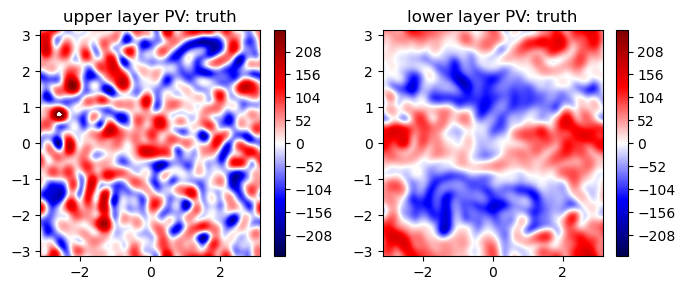

In [20]:
colorlim=(256, 256)
plot_contour_fields(q1_t, q2_t, 'truth', colorlim)
plt.savefig('./Lagrangian_DA/truth_q_beta22.png')
plt.show()

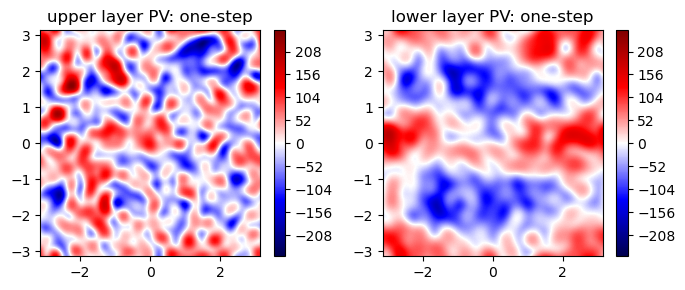

In [20]:
colorlim=(256, 256)
plot_contour_fields(q1_t_lsm, q2_t_lsm, 'one-step', colorlim)
plt.savefig('./Lagrangian_DA/LSM_q_beta22_L256.png')
plt.show()

# 3. Parameter estimation

## 3.1 Backward sampling

In [7]:
from Lagrangian_DA import sampling, back_sampling

dt = 1e-3
N = 100000
K = 128
s_rate = 16
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
# truncate parameter
r_cut = 16
style = 'circle'

da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256_iter1.npz')
mu_eigen_t = da_pos['mu_t']
R_eigen_t = da_pos['R_t']
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h32.npz')
gamma = est_params['gamma']
omega = est_params['omega']
f = est_params['f']
sigma = est_params['sigma']
Sigma = np.diag(truncate(sigma, r_cut, style=style).flatten(order='F')) # assume independent noise
a0 = truncate(f, r_cut, style=style).flatten(order='F')
a1 = -np.diag(truncate(gamma, r_cut, style=style).flatten(order='F')) + 1j * np.diag(truncate(omega, r_cut, style=style).flatten(order='F')) 

# sampling trajectories
noise = np.random.randn(K, K, 2, N, 1) + 1j * np.random.randn(K, K, 2, N, 1)
noise = map_conj_symm(noise, r1)
noise = truncate(noise, r_cut, style)
noise = np.transpose(np.reshape(noise, (-1, N, 1), order='F'), (1,2,0))

psitau_k_s = sampling(1, dt, mu_eigen_t, R_eigen_t, Sigma, a0, a1, noise)
psitau_k_s = psitau_k_s[0, :, :]
mu_t_s = psitau_k_s.reshape((psitau_k_s.shape[0] // 2, 2, -1), order='F')
psi_k_s = mu_t_s[:,0,:]
tau_k_s = mu_t_s[:,1,:]

## 3.2 Recalibrate models

In [11]:
psi_k_s = inv_truncate(psi_k_s[:, s_rate-1::s_rate], r_cut, K, style)
tau_k_s = inv_truncate(tau_k_s[:, s_rate-1::s_rate], r_cut, K, style)

In [12]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_s, tau_k_s, K, dt*s_rate, Lag=250, r_cut=r_cut, style=style, corr_noise=False)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.savez('../data/est_paras_ou_K128_beta22_tr_h32_iter2.npz', **est_params)

/grad/wang3262/Proj_2_DAnPE_CGKN/code/LSM_QG.py:123: OptimizeWarning: Covariance of the parameters could not be estimated
  x1, _ = curve_fit(ACF, tt, acf_psi, p0=x0, check_finite=True, maxfev=2000)
/grad/wang3262/Proj_2_DAnPE_CGKN/code/LSM_QG.py:131: OptimizeWarning: Covariance of the parameters could not be estimated
  x2, _ = curve_fit(ACF, tt, acf_tau, p0=x0, check_finite=True, maxfev=2000)


In [60]:
# iter0
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h32_iter0.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

# truth
print('gamma: ',np.max(gamma_est.real), np.min(gamma_est.real))
print('omega: ',np.max(omega_est.real), np.min(omega_est.real))
print('f: ',np.max(f_est.real), np.max(f_est.imag), np.min(f_est.real), np.min(f_est.imag))
print('sigma: ',np.max(sigma_est.real), np.min(sigma_est.real))

gamma:  16.219714600710876 0.0
omega:  13.051667689440505 -13.051667689440505
f:  3573.421348622543 12064.519768331886 -3342.9168053537664 -12064.519768331886
sigma:  7269.200445117369 0.0


In [54]:
# iter1 
print('gamma: ',np.max(gamma_est.real), np.min(gamma_est.real))
print('omega: ',np.max(omega_est.real), np.min(omega_est.real))
print('f: ',np.max(f_est.real), np.max(f_est.imag), np.min(f_est.real), np.min(f_est.imag))
print('sigma: ',np.max(sigma_est.real), np.min(sigma_est.real))

gamma:  30.741960517893272 0.0
omega:  13.5280241002642 -13.5280241002642
f:  3989.576188428742 8305.889917538687 -3537.4369639339557 -8305.889917538687
sigma:  6718.135976553187 0.0


In [13]:
# iter 2
print('gamma: ',np.max(gamma_est.real), np.min(gamma_est.real))
print('omega: ',np.max(omega_est.real), np.min(omega_est.real))
print('f: ',np.max(f_est.real), np.max(f_est.imag), np.min(f_est.real), np.min(f_est.imag))
print('sigma: ',np.max(sigma_est.real), np.min(sigma_est.real))

gamma:  75.51503290134181 0.0
omega:  16.78474824120832 -16.78474824120832
f:  3796.375552203457 8265.460205436098 -3506.773243564294 -8265.460205436098
sigma:  6395.800794673838 0.0


In [3]:
# truth paramaters of LSMs
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h40.npz')
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

# truth
print('gamma: ',np.max(gamma_est.real), np.min(gamma_est.real))
print('omega: ',np.max(omega_est.real), np.min(omega_est.real))
print('f: ',np.max(f_est.real), np.max(f_est.imag), np.min(f_est.real), np.min(f_est.imag))
print('sigma: ',np.max(sigma_est.real), np.min(sigma_est.real))

gamma:  15.762773015705609 0.0
omega:  12.582455583140149 -12.582455583140149
f:  3590.666700057357 9247.63207555214 -3779.702538068291 -9247.63207555214
sigma:  6065.813574601146 0.0


In [30]:
# calculate error
n_iter = list(range(3))
rmses_m_lsm = []
l2errs = []

# truth paramaters of LSMs
data_t = []
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h40.npz')
data_t.append(est_params['gamma'])
data_t.append(est_params['omega'])
data_t.append(est_params['f'])
data_t.append(est_params['sigma'])

for ii in n_iter:
    data = []
    est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h32_iter{:d}.npz'.format(ii))
    data.append(est_params['gamma'])
    data.append(est_params['omega'])
    data.append(est_params['f'])
    data.append(est_params['sigma'])

    rmse = np.zeros(4)
    l2err = np.zeros(4)
    for i in range(4):
        rmse_xy = np.sqrt(np.mean((data[i] - data_t[i])**2, axis=(0,1)))
        rmse[i] = np.mean(np.abs(rmse_xy))
        l2err[i] = np.linalg.norm(data[i] - data_t[i])

    rmses_m_lsm.append(rmse)
    l2errs.append(l2err)
rmses_m_lsm = np.array(rmses_m_lsm)
l2errs = np.array(l2errs)

# relative error
for i in range(4):
    l2errs[:, i] = l2errs[:, i] / np.linalg.norm(data_t[i])

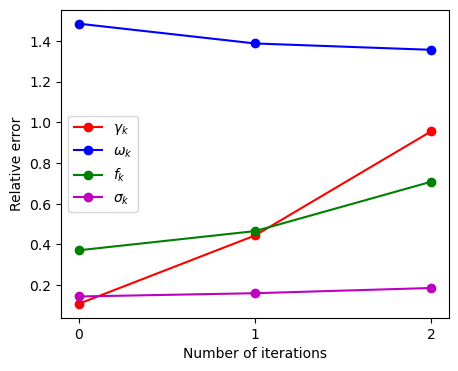

In [34]:
# Create the plot
plt.figure(figsize=(5, 4))
labels = ['$\gamma_k$', '$\omega_k$', '$f_k$', '$\sigma_k$']
colors = ['r','b','g','m']
for i in range(4):
    plt.plot(n_iter, l2errs[:, i], label=labels[i], linestyle='-', marker='o', color=colors[i])
plt.legend()
# plt.xscale('log', base=2)  # Set x-axis to log scale with base 2
plt.xticks(n_iter)
plt.xlabel('Number of iterations')
plt.ylabel(r'Relative error')
plt.savefig('../figure/paramserr_lsm.png', dpi=100)
plt.show()

In [38]:
# truncate parameter
r_cut = 16
style = 'circle'

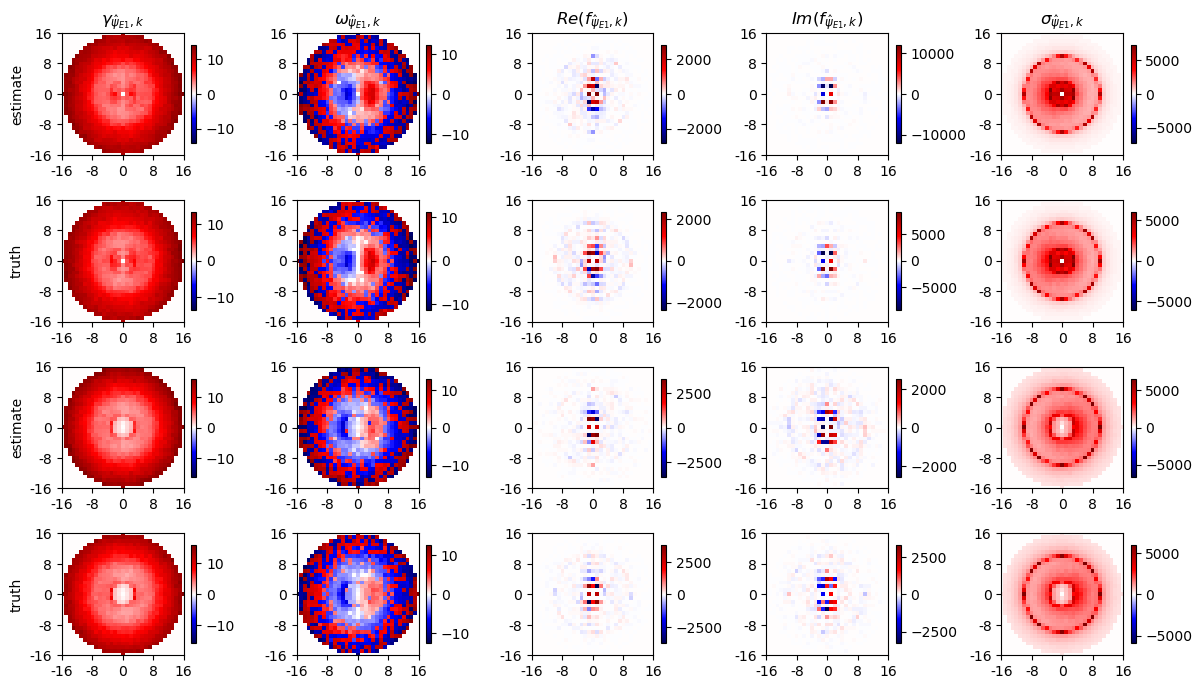

In [64]:
# Plot modes of omega
nrow = 4; ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(12,7))

data = []
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h32_iter0.npz')
data.append(est_params['gamma'])
data.append(est_params['omega'])
data.append(est_params['f'])
data.append(est_params['sigma'])
data_t = []
est_params = np.load('../data/est_paras_ou_K128_beta22_tr_h40.npz')
data_t.append(est_params['gamma'])
data_t.append(est_params['omega'])
data_t.append(est_params['f'])
data_t.append(est_params['sigma'])

dataplot = np.zeros((K,K,nrow, ncol))
for col in range(ncol):
    if col == 2:
        dataplot[:,:,0,col] = data[col][:,:,0].real
        dataplot[:,:,1,col] = data_t[col][:,:,0].real
        dataplot[:,:,2,col] = data[col][:,:,1].real
        dataplot[:,:,3,col] = data_t[col][:,:,1].real
    elif col == 3:
        dataplot[:,:,0,col] = data[2][:,:,0].imag
        dataplot[:,:,1,col] = data_t[2][:,:,0].imag
        dataplot[:,:,2,col] = data[2][:,:,1].imag
        dataplot[:,:,3,col] = data_t[2][:,:,1].imag
    elif col == 4:
        dataplot[:,:,0,col] = data[3][:,:,0]
        dataplot[:,:,1,col] = data_t[3][:,:,0]
        dataplot[:,:,2,col] = data[3][:,:,1]
        dataplot[:,:,3,col] = data_t[3][:,:,1]
    else:
        dataplot[:,:,0,col] = data[col][:,:,0]
        dataplot[:,:,1,col] = data_t[col][:,:,0]
        dataplot[:,:,2,col] = data[col][:,:,1]
        dataplot[:,:,3,col] = data_t[col][:,:,1]
        
dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(nrow):
    for j in range(ncol):
        n_tick = K//8
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        fig.colorbar(im, ax=axs[i,j], shrink=0.8)

axs[0,0].set_title(r'$\gamma_{{\hat{\psi}_{E1}},k}$')
axs[0,1].set_title(r'$\omega_{{\hat{\psi}_{E1}},k}$')
axs[0,2].set_title(r'$Re(f_{{\hat{\psi}_{E1}},k})$')
axs[0,3].set_title(r'$Im(f_{{\hat{\psi}_{E1}},k})$')
axs[0,4].set_title(r'$\sigma_{{\hat{\psi}_{E1}},k}$')
axs[0,0].set_ylabel('estimate')
axs[1,0].set_ylabel('truth')
axs[2,0].set_ylabel('estimate')
axs[3,0].set_ylabel('truth')

plt.tight_layout()
plt.savefig('../figure/params_k_lsm_iter0.png', dpi=100)
plt.show()

## 3.3 Parameter estimation

In [16]:
# load data
data_path = '../data/qg/QG_DATA_topo40_nu1e-12_beta22_K128_dt1e-3_subs.mat'
with h5py.File(data_path, 'r') as file: 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])

In [6]:
dt = 1e-3
N = 100000
K = 128
s_rate = 16
eigens = np.load('../data/eigens_K128_beta22.npz')
r1 = eigens['r1']
r2 = eigens['r2']
# truncate parameter
r_cut = 16
style = 'circle'

da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr_L256_iter2.npz')
mu_t_lsm = da_pos['mu_t']

# reshape flattened variables to two modes matrices
psi_k_pos_lsm, tau_k_pos_lsm = mu2psi(mu_t_lsm, K, r_cut, style)
psi1_k_pos_lsm, psi2_k_pos_lsm = eigen2layer(K,r_cut,r1,r2,psi_k_pos_lsm,tau_k_pos_lsm,style)

In [ ]:
# sub = 10
hk = params_est(K, dt, psi1_k_pos_lsm[:, :, :10000], psi2_k_pos_lsm[:, :, :10000], kd=10, beta=22, kappa=9, nu=1e-12, U=1, r_cut=16, style='circle')